# Import libraries


In [ ]:
# Import necessary libraries for data manipulation, time series analysis, and plotting
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
import random

# Import additional libraries needed
from statsmodels.tsa.stattools import adfuller # For Augmented Dickey-Fuller test (ADF)
from statsmodels.graphics.tsaplots import plot_acf # For plotting the Auto-Correlation Function (ACF)

# Data loading and vizualisation

In [ ]:
# Load datasets from CSV files (X: features, Y: target for two traces: main and FedCSIS)
X = pd.read_csv("../data/X.csv")
Y = pd.read_csv("../data/Y.csv")["DispFrames"]

# Another dataset for comparison
X_fedcsis = pd.read_csv("../data/FedCSIS_X.csv")
Y_fedcsis = pd.read_csv("../data/FedCSIS_Y.csv")["host1619_/"]

# Preprocessing: Remove TimeStamp and missing values
timestamp = X["TimeStamp"]
X.drop(X.columns[0:2], axis=1, inplace=True)
X.dropna(how='any', inplace=True)
X_fedcsis.dropna(how='any', inplace=True)

# Data preparation: Standardization and Outlier Removal

In [ ]:
# 1. Standardization and Outlier Removal
Y_std = StandardScaler().fit_transform(Y.values.reshape(-1, 1)).flatten()
Y_fedcsis_std = StandardScaler().fit_transform(Y_fedcsis.values.reshape(-1, 1)).flatten()

# Function to remove outliers by keeping 99% of the data based on deviation from the mean
def remove_outliers_to_keep_99_percent(data):
    threshold = np.percentile(np.abs(data - np.mean(data)), 99)
    return data[np.abs(data - np.mean(data)) < threshold]

# Apply outlier removal to both datasets
Y_filtered = remove_outliers_to_keep_99_percent(Y_std)
Y_fedcsis_filtered = remove_outliers_to_keep_99_percent(Y_fedcsis_std)

# Augmented Dickey-Fuller Test on Random Sequences

In [ ]:
# Perform Augmented Dickey-Fuller (ADF) Test for time series stationarity on random sequences
def perform_random_adf_tests(series, lengths, significance_levels):
    for length in lengths:
        for level in significance_levels:
            # Ensure a non-constant sequence is selected
            while True:
                start_idx = random.randint(0, len(series) - length) # Random start index
                sample = series[start_idx:start_idx + length] # Take a subsequence
                if sample.max() != sample.min(): # Ensure the sample is not constant
                    break

            try:
                result = adfuller(sample, autolag='AIC') # Perform ADF test
                print(f'Length: {length}, Significance Level: {level}%')
                print(f'ADF Statistic: {result[0]}, p-value: {result[1]}')
                critical_value_key = f'{"1%" if level == 1 else "5%" if level == 5 else "10%"}' # Critical value key for selected significance level
                print(f'Critical Value at {level}%: {result[4][critical_value_key]}')
            except ValueError as e:
                print(f"Error performing ADF test for length {length} and level {level}: {e}")
                
# Perform ADF tests on filtered data (main trace and FedCSIS trace)
print("Performing the tests on the KTH trace... \n\n")
perform_random_adf_tests(Y_filtered, lengths=[50, 500, 5000], significance_levels=[1, 2, 5])
print("\n\n")
print("Performing the tests on the FedCSIS trace... \n\n") # There are only 1916 samples so we can't do 5000 !
perform_random_adf_tests(Y_fedcsis_filtered, lengths=[50, 500], significance_levels=[1, 2, 5])

Performing the tests on the KTH trace... 


Length: 50, Significance Level: 1%
ADF Statistic: -7.000000000000001, p-value: 7.363798725300478e-10
Critical Value at 1%: -3.5714715250448363
Length: 50, Significance Level: 2%
ADF Statistic: -7.000000000000003, p-value: 7.363798725300424e-10
Critical Value at 2%: -2.5993358475635153
Length: 50, Significance Level: 5%
ADF Statistic: -5.066155821585819, p-value: 1.6390453025561194e-05
Critical Value at 5%: -2.937069375
Length: 500, Significance Level: 1%
ADF Statistic: -9.25474507037624, p-value: 1.4598976272934318e-15
Critical Value at 1%: -3.4437386290417082
Length: 500, Significance Level: 2%
ADF Statistic: -10.467211036221356, p-value: 1.3122516094330482e-18
Critical Value at 2%: -2.5698767442886696
Length: 500, Significance Level: 5%
ADF Statistic: -0.6701138790841533, p-value: 0.8543396084440542
Critical Value at 5%: -2.867567599912013
Length: 5000, Significance Level: 1%
ADF Statistic: -4.699018775388075, p-value: 8.451066901945949e-05

# Auto-Correlation Function (ACF) Plots

<Figure size 1200x600 with 0 Axes>

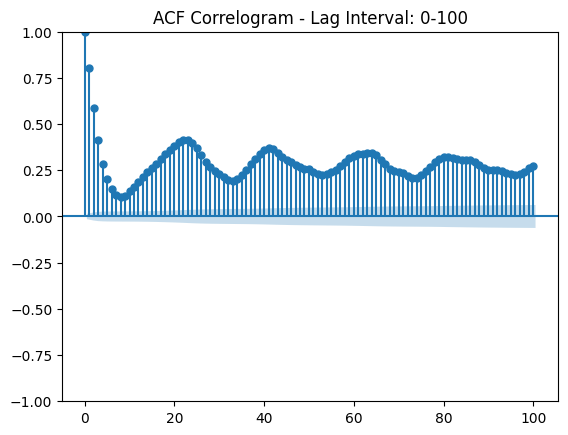

<Figure size 1200x600 with 0 Axes>

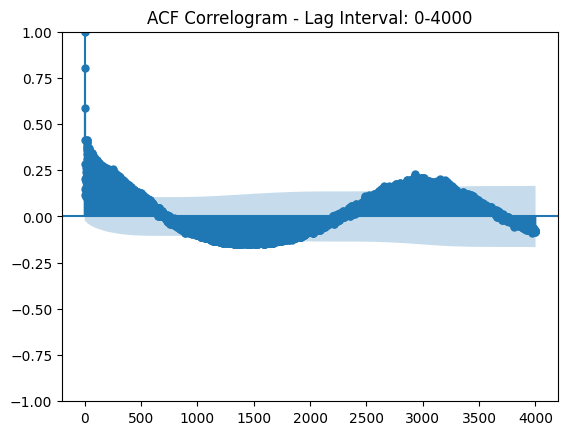

In [ ]:
# Plot Auto-Correlation Function (ACF) for filtered datasets
def plot_acf_correlogram(data, lag_intervals):
    for lags in lag_intervals:
        plt.figure(figsize=(12, 6))
        plot_acf(data, lags=lags, alpha=0.05) # Plot ACF for the given lag
        plt.title(f'ACF Correlogram - Lag Interval: 0-{lags}')
        plt.show()
        
# Plot ACF for both datasets with different lag intervals
plot_acf_correlogram(Y_filtered, lag_intervals=[100, 4000])

<Figure size 1200x600 with 0 Axes>

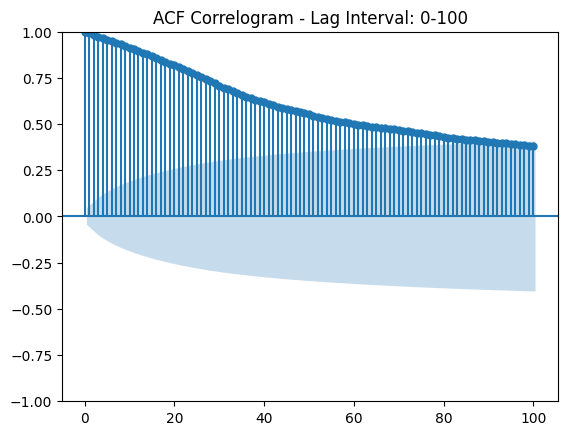

<Figure size 1200x600 with 0 Axes>

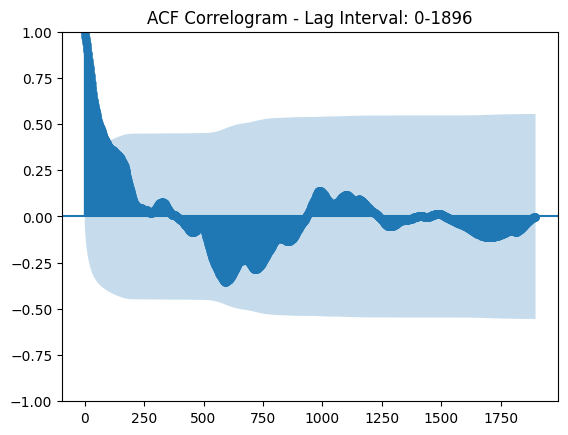

In [ ]:
plot_acf_correlogram(Y_fedcsis_filtered, lag_intervals=[100, 1896])

## Quiz 3

In [ ]:
from statsmodels.tsa.ar_model import AutoReg # Import AutoRegression model
from statsmodels.tsa.arima.model import ARIMA # Import ARIMA model

X_quiz = np.array([1, 3, 5, 2, 6, 4, 8, 7, 6, 10, 13, 9, 11, 12])

# AutoRegression model with p = 1
model_ar = AutoReg(X_quiz, lags=1)
result_ar = model_ar.fit()

# Forecasting the next two values (horizon = 2) using AR model
forecast_ar = result_ar.predict(start=len(X_quiz), end=len(X_quiz) + 1)
print(forecast_ar)

[11.05450942 10.41918472]


In [ ]:
# Fit Moving Average (MA) model with parameters q = 1, d = 1, h = 2
model_ma = ARIMA(X_quiz, order=(0, 1, 1))
result_ma = model_ma.fit()
forecast_ma = result_ma.forecast(steps=2)
print(forecast_ma)

[11.43636034 11.43636034]


In [ ]:
# Autoregressive Integrated Moving Average model with q = 1, d=1 and h = 2
model_arima = ARIMA(X_quiz, order=(1, 1, 1))
result_arima = model_arima.fit()

# Forecast next two values using ARIMA model
forecast_arima = result_arima.forecast(steps=2)
print(forecast_arima)

[11.35638926 11.5164673 ]


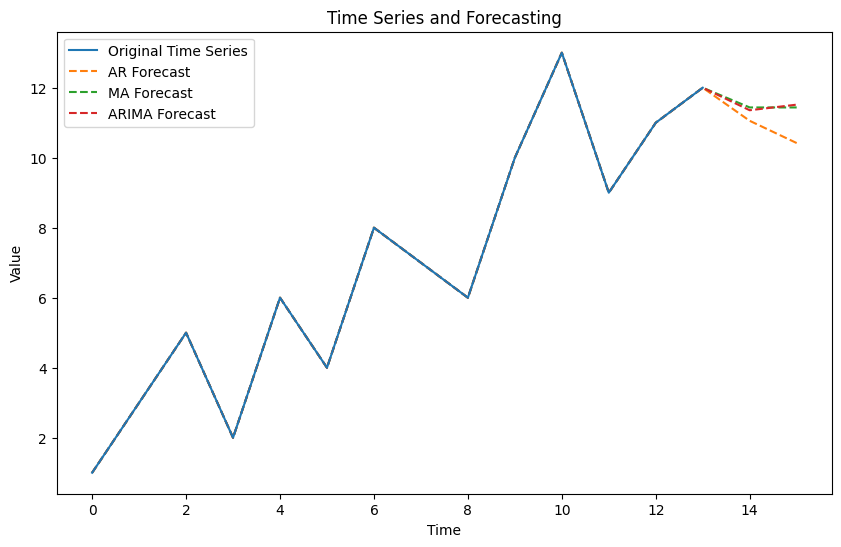

In [ ]:
# Plot original series and the forecasted values from AR, MA, and ARIMA models

X_ar = np.append(X_quiz,forecast_ar) # Extend original series with AR forecast
X_ma = np.append(X_quiz,forecast_ma) # Extend with MA forecast
X_arima = np.append(X_quiz,forecast_arima) # Extend with ARIMA forecast

# Plotting the time series and forecasts
plt.figure(figsize=(10, 6))
plt.plot(X_quiz, label='Original Time Series',zorder = 3)
plt.plot(X_ar, label='AR Forecast', linestyle='dashed',zorder = 2)
plt.plot(X_ma, label='MA Forecast', linestyle='dashed',zorder = 2)
plt.plot(X_arima, label='ARIMA Forecast', linestyle='dashed',zorder = 2)

plt.title('Time Series and Forecasting')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

